In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import FeatureImportances

from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('genie-cohorts.csv')
df['cht'] = df['cht'].replace({
    0: 'Asian Female', 
    1: 'Asian Male', 
    2: 'Black Female', 
    3: 'Black Male', 
    4: 'White Female', 
    5: 'White Male'
})
df

,tissuename,ABI1,ABL1,ABL2,ACKR3,ACSL6,ACVR1,ACVR2A,AFDN,AFF1,AFF3,AFF4,AKAP9,AKT1,AKT2,AKT3,ALDH2,ALK,AMER1,APC,AR,ARAF,ARHGAP26,ARHGEF12,ARID1A,ARID1B,ARID2,ARNT,ASPSCR1,ASXL1,ASXL2,ATF1,ATIC,ATM,ATP1A1,ATP2B3,ATR,ATRX,AXIN1,AXIN2,B2M,BAP1,BARD1,BCL10,BCL11A,BCL11B,BCL2,BCL2L12,BCL3,BCL6,...,THRAP3,TLX1,TLX3,TMEM127,TMPRSS2,TNFAIP3,TNFRSF14,TNFRSF17,TOP1,TP53,TP63,TPM3,TPM4,TPR,TRAF7,TRIM24,TRIM27,TRIM33,TRIP11,TRRAP,TSC1,TSC2,TSHR,U2AF1,UBR5,USP6,USP8,VAV1,VHL,VTI1A,WAS,WIF1,WNK2,WRN,WT1,WWTR1,XPA,XPC,XPO1,YWHAE,ZBTB16,ZFHX3,ZMYM2,ZMYM3,ZNF331,ZNF384,ZNF521,ZNRF3,ZRSR2,cht
0,GENIE-COLU-00271-01,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Asian Female
1,GENIE-COLU-00274-01,0,1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Asian Female
2,GENIE-MSK-P-0007864-T01-IM5,0,-1,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0,0,-1,-1,0,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,-1,...,0,0,0,-1,-1,-1,-1,0,-1,-1,-1,0,0,0,-1,0,0,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,0,0,0,-1,Asian Female
3,GENIE-MSK-P-0007864-T02-IM6,0,-1,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0,0,-1,-1,0,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,-1,...,0,0,0,-1,-1,-1,-1,0,-1,-1,-1,0,0,0,-1,0,0,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,0,0,0,0,0,-1,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,-1,Asian Female
4,GENIE-MSK-P-0007864-T03-IM6,0,-1,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0,0,-1,-1,0,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,-1,...,0,0,0,-1,-1,-1,-1,0,-1,-1,-1,0,0,0,-1,0,0,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,0,0,0,0,0,-1,-1,0,0,-1,0,0,-1,0,0,0,0,0,0,-1,Asian Female
5,GENIE-MSK-P-0008131-T01-IM5,0,-1,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,-1,1,-1,0,0,-1,-1,0,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,-1,...,0,0,0,-1,-1,-1,-1,0,-1,0,-1,0,0,0,-1,0,0,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,0,0,0,-1,Asian Female
6,GENIE-MSK-P-0008289-T01-IM5,0,-1,0,0,0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,-1,-1,0,0,-1,-1,-1,0,0,-1,-1,0,0,-1,0,0,-1,-1,-1,-1,-1,-1,-1,-1,0,0,-1,0,0,-1,...,0,0,0,-1,-1,-1,-1,0,-1,-1,-1,0,0,0,-1,0,0,0,0,0,-1,-1,-1,-1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,0,0,0,-1,Asian Female
7,GENIE-COLU-00455-01,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Asian Female
8,GENIE-COLU-00455-02,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Asian Female
9,GENIE-COLU-00462-01,0,-1,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Asian Female


In [3]:
y = df['cht']
X = df.drop(columns=['tissuename', 'cht']) # drop the target column

In [4]:
# find features with same value for all samples and drop them
nunique = X.nunique()
cols_to_drop = nunique[nunique <= 1].index # 0 if all are missing, 1 if ther is only one catgeory/value
X_train = X.drop(cols_to_drop, axis='columns').reset_index(drop=True)

In [12]:
imputer = KNNImputer(missing_values=0, n_neighbors=5, weights='uniform') 
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
# Adjust imputed values based on threshold
threshold = 0
X_train_imputed_adjusted = X_train_imputed.applymap(lambda x: 1.0 if x > threshold else (-1.0 if x < threshold else 0))
X_train_imputed_adjusted.shape

(13485, 557)

In [14]:
X_train_imputed_adjusted

,ABL1,ABL2,ACVR1,ACVR2A,AFDN,AFF1,AFF3,AKAP9,AKT1,AKT2,AKT3,ALK,AMER1,APC,AR,ARAF,ARHGAP26,ARHGEF12,ARID1A,ARID1B,ARID2,ARNT,ASPSCR1,ASXL1,ASXL2,ATF1,ATM,ATR,ATRX,AXIN1,AXIN2,B2M,BAP1,BARD1,BCL10,BCL11A,BCL11B,BCL2,BCL2L12,BCL3,BCL6,BCL7A,BCL9,BCOR,BCORL1,BCR,BIRC3,BLM,BMPR1A,BRAF,...,TET1,TET2,TFE3,TFEB,TFG,TFRC,TGFBR2,TLX1,TLX3,TMEM127,TMPRSS2,TNFAIP3,TNFRSF14,TNFRSF17,TOP1,TP53,TP63,TPM3,TPR,TRAF7,TRIM24,TRIM33,TRIP11,TRRAP,TSC1,TSC2,TSHR,U2AF1,UBR5,USP6,USP8,VHL,WAS,WNK2,WRN,WT1,WWTR1,XPA,XPC,XPO1,YWHAE,ZBTB16,ZFHX3,ZMYM2,ZMYM3,ZNF331,ZNF384,ZNF521,ZNRF3,ZRSR2
0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.

<Axes: xlabel='FGFR4', ylabel='Percent'>

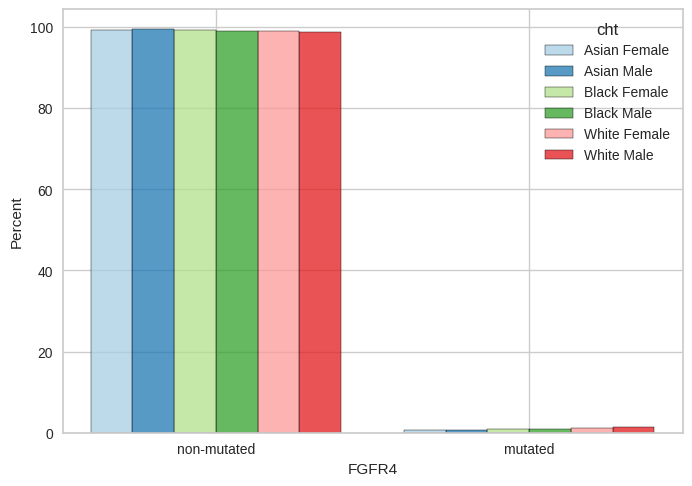

In [15]:
df_prepared = pd.concat([y, X_train_imputed_adjusted], axis=1)
df_prepared['FGFR4'] = df_prepared['FGFR4'].replace({-1: 'non-mutated', 0: 'unknown', 1: 'mutated'})
sns.histplot(x=df_prepared["FGFR4"], hue=df_prepared["cht"], multiple="dodge", shrink=0.8,
                  stat = 'percent', common_norm=False, palette="Paired")

In [16]:
params = {
    "bootstrap": True, # necessary for oob_score --> default: True for Random Forest, False for Extremely Random Forest
    "class_weight": 'balanced',
    "n_estimators": 500,
    "n_jobs": -1,
    "max_depth": 100,
    "max_features": 0.8,
    "min_samples_leaf": 1,
    "oob_score": True,
    "random_state":  42,
  }

In [17]:
forest = RandomForestClassifier(**params)
forest = forest.fit(X_train_imputed_adjusted, y)
forest.score(X_train_imputed_adjusted, y)

0.6832035595105673

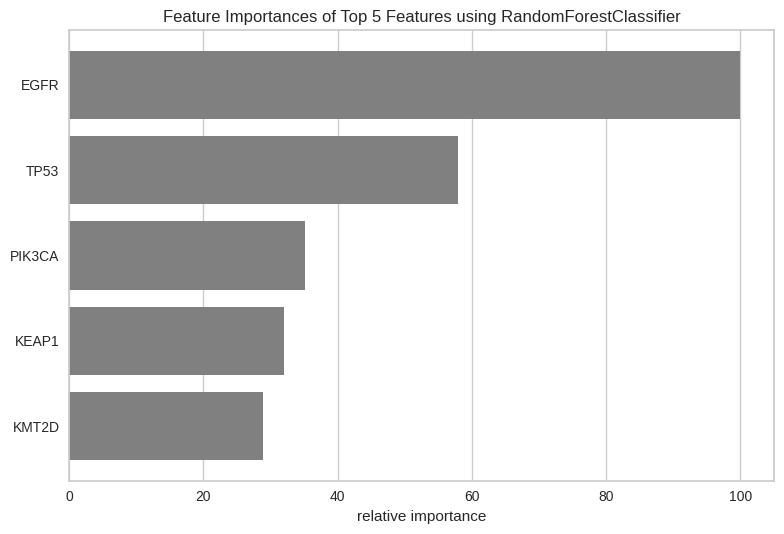

<Axes: title={'center': 'Feature Importances of Top 5 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [18]:
viz = FeatureImportances(forest, topn=5, is_fitted=True, relative=True, colors=["grey"])
viz.fit(X_train, y)
viz.show()